In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
import obonet
from tqdm import tqdm
import warnings

import os
warnings.filterwarnings('ignore')

from Dataset.GoDataset import GOTermDataset, get_class_frequencies_from_dataframe
from Model.ProtienGOClassifier_pl import ProteinGOClassifierLightning
from Dataset.utils import prepare_data, read_fasta

/home/tan/miniconda3/envs/cafa6/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

BASE_PATH = "/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction"


go_graph = obonet.read_obo(os.path.join(BASE_PATH, 'Train/go-basic.obo'))
print(f"Gene Ontology graph loaded with {len(go_graph)} nodes and {len(go_graph.edges)} edges.")

train_terms_df = pd.read_csv(os.path.join(BASE_PATH, 'Train/train_terms.tsv'), sep='\\t')
print(f"Training terms loaded. Shape: {train_terms_df.shape}")


train_fasta_path = os.path.join(BASE_PATH, 'Train/train_sequences.fasta')

test_fasta_path = os.path.join(BASE_PATH, 'Test/testsuperset.fasta')

ia_df = pd.read_csv(os.path.join(BASE_PATH, 'IA.tsv'), sep='\\t', header=None, names=['term_id', 'ia_score'])
ia_map = dict(zip(ia_df['term_id'], ia_df['ia_score']))
print(train_terms_df['aspect'].value_counts().reset_index())

train_seq = read_fasta(train_fasta_path)
test_seq = read_fasta(test_fasta_path)

Gene Ontology graph loaded with 40122 nodes and 77229 edges.
Training terms loaded. Shape: (537027, 3)
  aspect   count
0      P  250805
1      C  157770
2      F  128452
[io] Read 82404 sequences from /mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Train/train_sequences.fasta
[io] Read 224309 sequences from /mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Test/testsuperset.fasta


In [3]:
class GOTestDataset(Dataset):

    def __init__(self, sequences, tokenizer, max_length=512):
        self.sequences = sequences
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]

        # Tokenize protein sequence
        # Note: Add spaces between amino acids for better tokenization
        spaced_sequence = ' '.join(list(sequence))
        encoding = self.tokenizer(
            spaced_sequence,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'sequence': sequence, 
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
        }


def prepare_test_data(test_seq, top_k=100, test_size=0.2, random_state=42):


    print(f"Number of protein entries: {len(test_seq)}")

    # Step 5: Create sequences and labels lists
    sequences = [test_seq[entry] for entry in test_seq.keys()]

    print(f"Test samples: {len(sequences)}")

    return sequences

In [4]:
import json 
with open('/mnt/d/ML/Kaggle/CAFA6/checkpoints/asl_mild/configs.json', 'r') as f:
        configs = json.load(f)

In [5]:
model_name = configs['model_configs']['model_name']
top_k = configs['model_configs']['top_k']
max_length = configs['model_configs']['max_length']
batch_size = configs['training_configs']['batch_size']
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize tokenizer
print(f"Loading tokenizer: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)# do_lower_case=False)

prepare_test_data(test_seq)
test_dataset = GOTestDataset(
    prepare_test_data(test_seq),
    tokenizer,
    max_length=max_length
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

print("Created test dataset")

Loading tokenizer: facebook/esm2_t6_8M_UR50D
Number of protein entries: 224309
Test samples: 224309
Number of protein entries: 224309
Test samples: 224309
Created test dataset


In [6]:
model = ProteinGOClassifierLightning.load_from_checkpoint(
    '/mnt/d/ML/Kaggle/CAFA6/checkpoints/asl_mild/go-classifier-epoch=09-val_f1=0.2795.ckpt',
    strict=False
)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Freezing transformer parameters (will remain frozen)...

--- Model Parameter Summary ---
Total parameters: 18,729,017
Trainable parameters: 11,217,216
Percentage trainable: 59.89%
-------------------------------



In [8]:
num_workers = 2 
test_size = 0.2

data = prepare_data(train_terms_df, train_seq, ia_df, top_k=top_k, test_size=test_size)


train_dataset = GOTermDataset(
        data['train_sequences'],
        data['train_labels'],
        tokenizer,
        max_length=max_length
    )

val_dataset = GOTermDataset(
        data['val_sequences'],
        data['val_labels'],
        tokenizer,
        max_length=max_length
    )


train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True if num_workers > 0 else False
    )

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True if num_workers > 0 else False
)

Preparing data with top 64 GO terms...
Top 64 terms selected
Frequency range: 33713 to 603
Number of valid protein entries: 64323
Label matrix shape: (64323, 64)
Average labels per protein: 2.48
Label distribution - min: 603, max: 33713
Train samples: 51458
Validation samples: 12865


In [9]:
"""Validate the model - FIXED VERSION."""
model.to(device)
model.eval()
all_predictions = []
all_proba = []
all_sequences = []
with torch.no_grad():
    for batch in tqdm(train_loader, desc='Validating', leave=False):
        # seq = batch['sequence']
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        logits = model(input_ids, attention_mask)

        proba = torch.sigmoid(logits) 
        predictions = (proba > 0.5).float()

        # all_sequences.extend(seq)
        all_proba.append(proba.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# FIXED: Convert to boolean
all_predictions = np.vstack(all_predictions).astype(bool)
all_proba = np.vstack(all_proba).astype(float)
print(len(all_sequences)) #224,309)

0


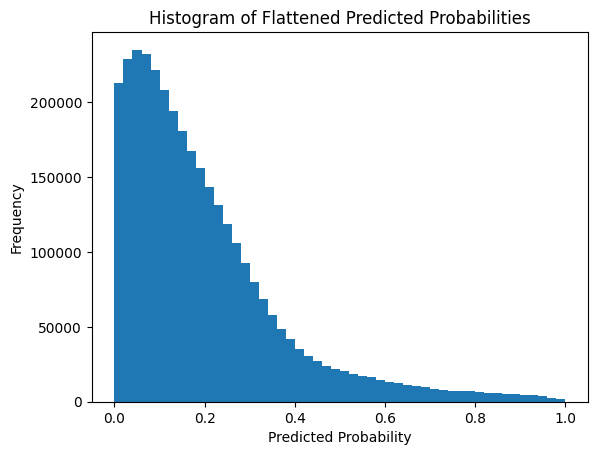

In [10]:
#create a histogram for all_proba
import matplotlib.pyplot as plt

plt.hist(all_proba.flatten(), bins=50)
plt.title('Histogram of Flattened Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

Positive ratio in 0 term: 0.5243	 Predicted positive ratio: 0.9124	 #No. of examples 26978
Positive ratio in 1 term: 0.2078	 Predicted positive ratio: 0.4909	 #No. of examples 10694
Positive ratio in -2 term: 0.0098	 Predicted positive ratio: 0.0	 #No. of examples 503
Positive ratio in -1 term: 0.0094	 Predicted positive ratio: 0.0024	 #No. of examples 485


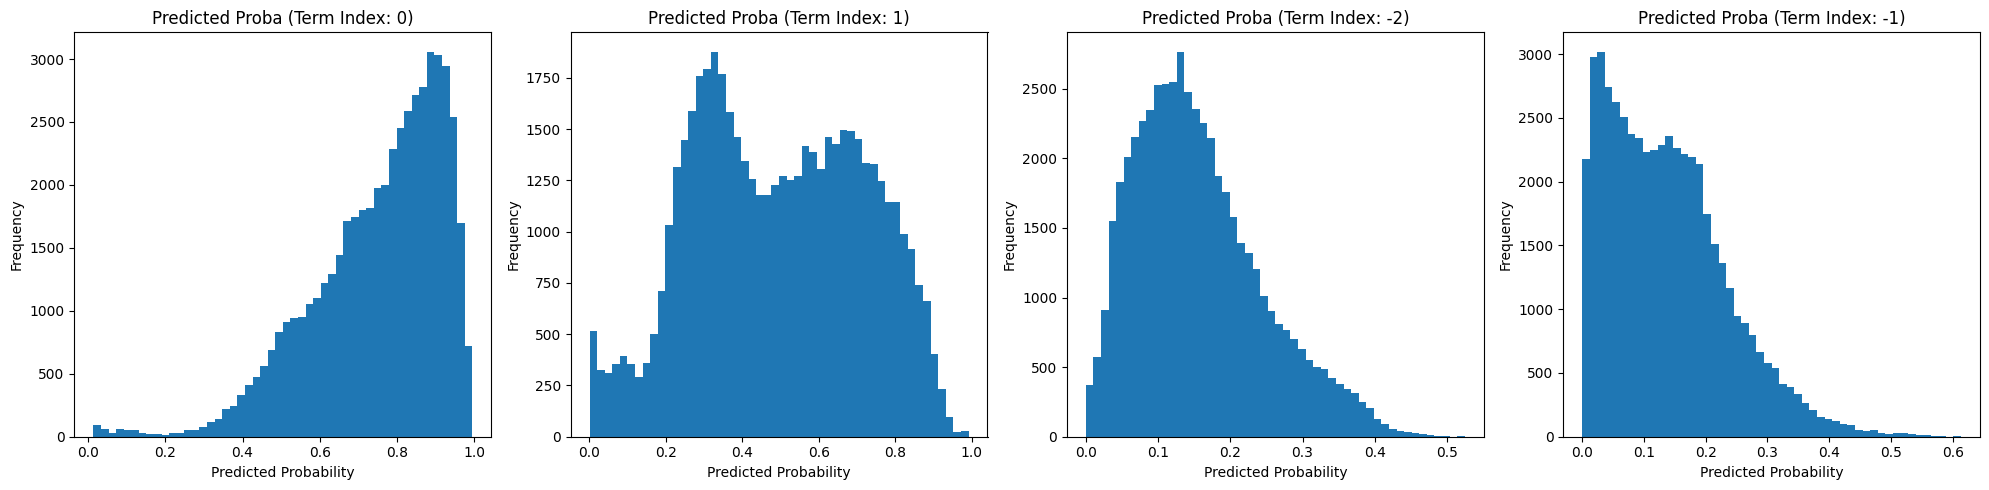

In [12]:
#create dual plot for all_proba 1st term and last term 

terms_list = [0, 1, -2, -1]

fig, axs = plt.subplots(nrows=1, ncols=len(terms_list), figsize=(len(terms_list)*5, 5))

#side by side histograms
for i, term in enumerate(terms_list):
    #create subplots 
    ax = axs[i]

    ax.hist(all_proba[:, term], bins=50)
    ax.set_title(f'Predicted Proba (Term Index: {term})')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Frequency')

    print(f"Positive ratio in {term} term: {(data['train_labels'][:, term].mean()).round(4) }\t Predicted positive ratio: {(all_predictions[:, term].mean()).round(4)}\t #No. of examples {data['train_labels'][:, term].sum()}")


plt.tight_layout()
# plt.show()

# first_term = 0
# last_term = -2

# plt.hist(all_proba[:, first_term], bins=50)
# plt.title('Histogram of Predicted Probabilities (1st Term)')
# plt.xlabel('Predicted Probability')
# plt.ylabel('Frequency')

# plt.subplot(1, 2, 2)
# plt.hist(all_proba[:, last_term], bins=50)
# plt.title('Histogram of Predicted Probabilities (Last Term)')
# plt.xlabel('Predicted Probability')
# plt.ylabel('Frequency')

# plt.tight_layout()
# plt.show()

# print()

# print(f"Positive ratio in {first_term} term: {(data['train_labels'][:, first_term].mean()).round(4) }\t Predicted positive ratio: {(all_predictions[:, first_term].mean()).round(4)}\t #No. of examples {data['train_labels'][:, first_term].sum()}")
# print(f"Positive ratio in {last_term} term: {(data['train_labels'][:, last_term].mean()).round(4)}\t Predicted positive ratio: {(all_predictions[:, last_term].mean()).round(4)}\t #No. of examples {data['train_labels'][:, last_term].sum()}")

In [13]:
#precison, recall and f1 score for first and last term
from sklearn.metrics import f1_score, precision_score, recall_score

for i, term in enumerate(terms_list):
    precision = precision_score(data['train_labels'][:, term], all_predictions[:, term])
    recall = recall_score(data['train_labels'][:, term], all_predictions[:, term])
    f1 = f1_score(data['train_labels'][:, term], all_predictions[:, term])
    print(f"Term {term}: \t Precision {precision: .4f} \t Recall {recall: .4f} \t F1{f1: .4f}")


Term 0: 	 Precision  0.5250 	 Recall  0.9136 	 F1 0.6668
Term 1: 	 Precision  0.2059 	 Recall  0.4863 	 F1 0.2893
Term -2: 	 Precision  0.0000 	 Recall  0.0000 	 F1 0.0000
Term -1: 	 Precision  0.0083 	 Recall  0.0021 	 F1 0.0033


In [14]:
import pandas as pd
top_terms = pd.read_csv('/mnt/d/ML/Kaggle/CAFA6/checkpoints/asl_loss_7_iter/top_terms_64.csv')
top_terms

,terms
0,GO:0005515
1,GO:0005634
2,GO:0005829
3,GO:0005886
4,GO:0005737
...,...
59,GO:0016324
60,GO:0007283
61,GO:0004672
62,GO:0009410


In [15]:
#wighted f1 score for all terms
def weighted_f1_score(y_true, y_pred, weights: np.ndarray = None):
    #do in parallel ?

    # True positives, false positives, false negatives
    tp = np.logical_and(y_pred, y_true).sum(axis=0).astype(float)
    fp = np.logical_and(y_pred, ~y_true).sum(axis=0).astype(float)
    fn = np.logical_and(~y_pred, y_true).sum(axis=0).astype(float)

    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)

    if weights is None:
        weights = np.ones_like(precision)

    total_weight = weights.sum()

    precision = (precision * weights).sum() /  total_weight
    recall = (recall * weights).sum() / total_weight

    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    if total_weight == 0:
        return 0.0, total_weight

    return f1


def fmax(y_pred, ia_map, weights: np.ndarray = None):
    best_f1 = 0.0
    best_threshold = 0.0

    for threshold in np.arange(0.0, 1.01, 0.01):
        binarized_preds = (y_pred >= threshold).astype(int)
        f1 = weighted_f1_score(data['train_labels'], binarized_preds, weights)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_f1, best_threshold


In [16]:
weights = [ia_map[term] for term in data['top_terms']]
weights = np.array(weights)
f1 = weighted_f1_score(data['train_labels'], all_predictions, weights)
print(f1)

0.03682938614258708


In [17]:
f, threshold = fmax(all_proba, ia_map, weights)
print(f, threshold)

0.05523747805500466 0.0


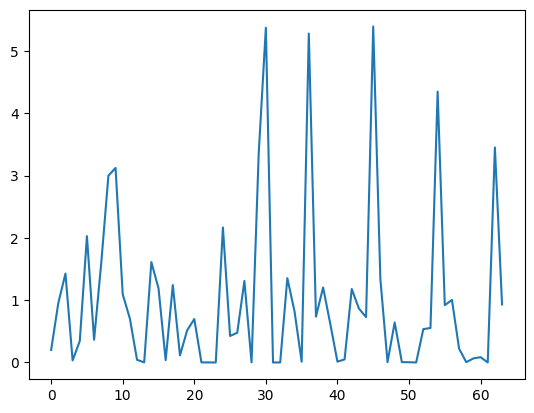

In [18]:
plt.plot(weights)

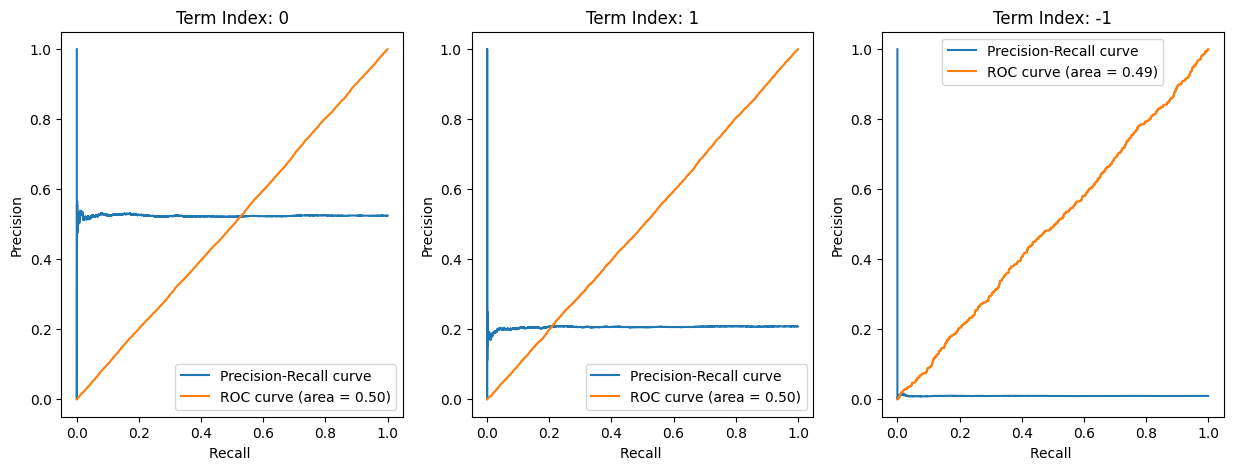

In [19]:
#create plots for precision-recall curve and ROC curve
from sklearn.metrics import precision_recall_curve, roc_curve, auc

terms_list = [0, 1, -1]

fig, axs = plt.subplots(nrows=1, ncols=len(terms_list), figsize=(len(terms_list)*5, 5))

for i, term in enumerate(terms_list):
    precision, recall, _ = precision_recall_curve(data['train_labels'][:, term], all_proba[:, term])
    fpr, tpr, _ = roc_curve(data['train_labels'][:, term], all_proba[:, term])
    roc_auc = auc(fpr, tpr)
    # Plot Precision-Recall curve
    ax = axs[i]
    ax.plot(recall, precision, label='Precision-Recall curve')
    ax.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.set_title(f'Term Index: {term}')
    ax.set_xlabel('Recall ')
    ax.set_ylabel('Precision')
    ax.legend()

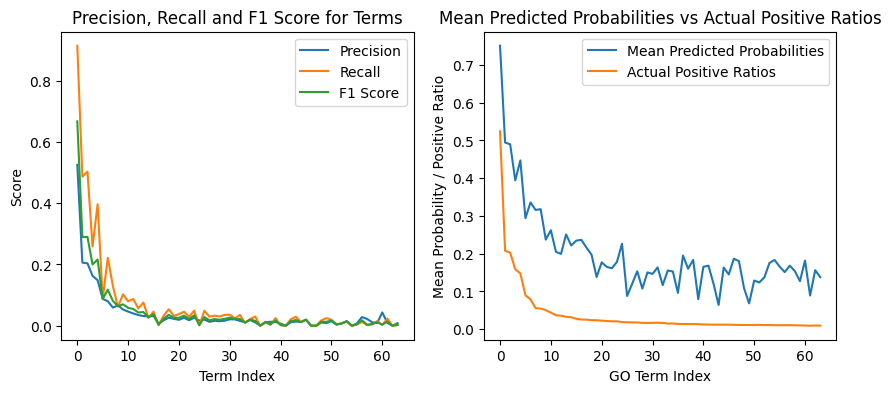

In [20]:
#plot precision, recall an f1 for all terms 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
precision_list = []
recall_list = []
f1_list = []
for i, term in enumerate(range(data['train_labels'].shape[1])):
    precision = precision_score(data['train_labels'][:, term], all_predictions[:, term])
    recall = recall_score(data['train_labels'][:, term], all_predictions[:, term])
    f1 = f1_score(data['train_labels'][:, term], all_predictions[:, term])
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

x = np.arange(data['train_labels'].shape[1])  # the label locations
width = 0.2  # the width of the bars
axs[0].plot(x, precision_list,  label='Precision')
axs[0].plot(x, recall_list,  label='Recall')
axs[0].plot(x, f1_list,  label='F1 Score')
axs[0].set_xlabel('Term Index')
axs[0].set_ylabel('Score')
axs[0].set_title('Precision, Recall and F1 Score for Terms')
axs[0].legend()

axs[1].plot(all_proba.mean(axis=0))
axs[1].plot(data['train_labels'].mean(axis=0))
axs[1].set_title('Mean Predicted Probabilities vs Actual Positive Ratios')
axs[1].set_xlabel('GO Term Index')
axs[1].set_ylabel('Mean Probability / Positive Ratio')
axs[1].legend(['Mean Predicted Probabilities', 'Actual Positive Ratios'])
plt.show()

## Loss Function Analysis

Alpha method: balanced 	 Loss: 0.1076
Alpha method: inverse 	 Loss: 0.1076
Alpha method: sqrt_inverse 	 Loss: 0.0745
Alpha method: effective_number 	 Loss: 0.1046


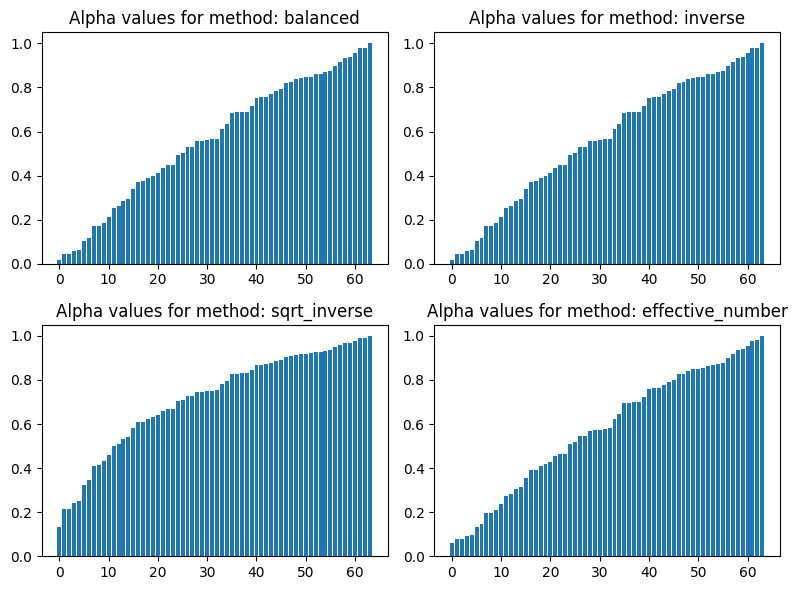

In [ ]:
from Utils.FocalLoss import PerClassFocalLoss, compute_per_class_alpha_from_frequencies

alpha_method_list = ['balanced', 'inverse', 'sqrt_inverse', 'effective_number']
 #inverse_frequency
beta = 0.9999
gamma = 1.0

fig, axs = plt.subplots(nrows=2, ncols=2 , figsize=(8,6))

for i, alpha_method in enumerate(alpha_method_list):
    
    per_class_alpha = compute_per_class_alpha_from_frequencies(
            class_frequencies,
            method=alpha_method,
            beta=beta
        )

    focal_loss = PerClassFocalLoss(alpha=per_class_alpha, gamma=gamma, reduction='mean')
    loss = focal_loss(
        torch.tensor(all_proba, dtype=torch.float32),
        torch.tensor(data['train_labels'], dtype=torch.float32)

    )
    #plot the aplha values
    axs[i // 2, i % 2].bar(range(len(per_class_alpha)), per_class_alpha)
    axs[i // 2, i % 2].set_title(f"Alpha values for method: {alpha_method}")

    print(f"Alpha method: {alpha_method} \t Loss: {loss.item():.4f}")
plt.tight_layout()